In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Učitavanje EDA mjerenja

Učitavanje y-osi akcelerometra ispita i sample rate akcelerometra.

In [2]:
def accy_load(exam_name):
    acc_m1 = []
    acc_sample_rate = 0
    for i in range(10):
        accY = pd.read_csv('Data/S%d/%s/ACC.csv' % (i+1, exam_name))
        accY.columns = ['x', 'y', 'z']
        accY = accY['y']
        if i==1: acc_sample_rate = accY.iloc[0]
        accY = accY.drop(0)
        acc_m1.append(accY)
    return acc_m1, acc_sample_rate

Da bi otkirli u koje vrijeme je svaki student počeo pisati ispit pogledat ćemo kada se dogodio skok na y-osi akcelerometra.

In [3]:
def accy_plot(acc_exam, exam_name, lim):
    figure, axis = plt.subplots(nrows=5, ncols=2, figsize=(10, 18))
    ind = 0
    for i in range(2):
        for j in range(5):
            axis[j, i].plot(acc_exam[ind])
            axis[j, i].set_xlim(lim)
            axis[j, i].set_title("S%d - %s" % (ind+1, exam_name))
            ind += 1

Učitavamo senzor elektrodermalne aktivnosti i oduzimamo mjerenja koja su mjerena prije početka ispita. Za svakog studenta drugačije je vrijeme. <br>
"Each participant was given an Empatica E4 device <b>approximately 5 min before the start</b> of each exam to be worn on their nondominant hand."

In [4]:
def eda_load(exam_name, acc_cuts, acc_sample_rate):
    eda_exam = []
    eda_sample_rate = 0
    for i in range(10):
        eda = pd.read_csv('Data/S%d/%s/EDA.csv' % (i+1, exam_name))
        if i==1: eda_sample_rate = eda.iloc[0][0]
        eda = eda.drop(0)

        # računamo koliko vremena smo oduzeli ACC y-osi
        time_accy = acc_cuts[i] / acc_sample_rate
        # računamo koliko mjerenja iz EDA trebamo maknuti na temelju vremena i sample_rate
        eda_remove = time_accy * eda_sample_rate

        eda = eda.iloc[int(eda_remove):]
        eda_exam.append(eda)
    return eda_exam, eda_sample_rate

# Granične frekvencije (cut-off frequencies)

In [5]:
d = {'Midterm 1': [0.002, 0.002, 0.0002, 0.002, 0.001, 0.002, 0.001, 0.0002, 0.002, 0.002],
          'Midterm 2': [0.002, 0.001, 0.0002, 0.002, 0.001, 0.002, 0.0002, 0.002, 0.002, 0.002],
          'Final': [0.002, 0.002, 0.001, 0.002, 0.001, 0.002, 0.0002, 0.002, 0.002, 0.002]}
cutoffs = pd.DataFrame(data=d)
cutoffs.index = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10']
display(cutoffs)

,Midterm 1,Midterm 2,Final
S1,0.0020,0.0020,0.0020
S2,0.0020,0.0010,0.0020
S3,0.0002,0.0002,0.0010
S4,0.0020,0.0020,0.0020
S5,0.0010,0.0010,0.0010
S6,0.0020,0.0020,0.0020
S7,0.0010,0.0002,0.0002
S8,0.0002,0.0020,0.0020
S9,0.0020,0.0020,0.0020
S10,0.0020,0.0020,0.0020


# Niskopropusni filter granične frekvencije za izdvajanje SC trendova

In [6]:
from scipy.signal import butter, filtfilt

def lowpass_butter_filter(data, cutoff, sampling_frequency, order=4):
    nyq = 0.5 * sampling_frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)

    return pd.DataFrame(y, columns=[data.columns[0]])

# Ekstrakcija značajki
Izdvajamo ovih devet značajki za Tw = 5, 15 i 30 min, a zatim treniramo zasebne klasifikatore za svaki Tw za svaki ispit.

In [7]:
def feature_extraction_from_exam(eda_exam, sample_rate, cutoffs, exam_time, time_read):
    all_students = []
    for i in range(10):
        eda_filter = lowpass_butter_filter(eda_exam[i], cutoffs[i], sample_rate, order=4)
        data = eda_filter.values.flatten()
        tw = int(time_read*60*sample_rate)
        t = int(exam_time*60*sample_rate)
                
        first_data = data[0:tw]
        second_data = data[int(t/2) - int(tw/2) : int(t/2) + int(tw/2)]
        third_data = data[t - tw: t]

        mi1 = np.mean(first_data)
        mi2 = np.mean(second_data)
        mi3 = np.mean(third_data)

        sigma1 = np.var(first_data)
        sigma2 = np.var(second_data)
        sigma3 = np.var(third_data)

        ro = mi2 / (mi1 + mi3)
        diff = np.array(third_data) - np.array(first_data)
        mi_diff = np.mean(diff)
        sigma_diff = np.var(diff)

        x = [mi1, mi2, mi3, sigma1, sigma2, sigma3, ro, mi_diff, sigma_diff]
        all_students.append(x)
        
    return pd.DataFrame(all_students)

 # Bodovi ispita

In [8]:
grades = pd.read_csv('Data/Student Grades.csv')
m1grades = grades['Midterm 1'].values
m2grades = grades['Midterm 2'].values
fgrades = grades['Final'].values
print(m1grades)
print(m2grades)
print(fgrades)

[78 82 77 75 67 71 64 92 80 89]
[82 85 90 77 77 64 33 88 39 64]
[182 180 188 149 157 175 110 184 126 116]


### Svakoj značajki dodjeljujemo oznaku visoke ili niske ocjene, tj. vektor na temelju kojeg saznajemo je li sudionik postigao više ili jednako od 80%.

In [9]:
def grade_labeling(grades, max_points):
    y = []
    for g in grades:
        if (g >= 0.8 * max_points):
            y.append(1)
        else:
            y.append(0)
    return pd.DataFrame(y)

# KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

def KNN_dataframe(data, y):
    kf = KFold(n_splits = 10)
    score = []
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        x_train = data.loc[train_index]
        x_test = data.loc[test_index]
        y_train = y.loc[train_index]
        y_test = y.loc[test_index]

        neigh = KNeighborsClassifier(n_neighbors=3).fit(np.array(x_train), np.array(y_train))
        score.append(neigh.score(x_test, y_test))
    return score

# Midterm 1

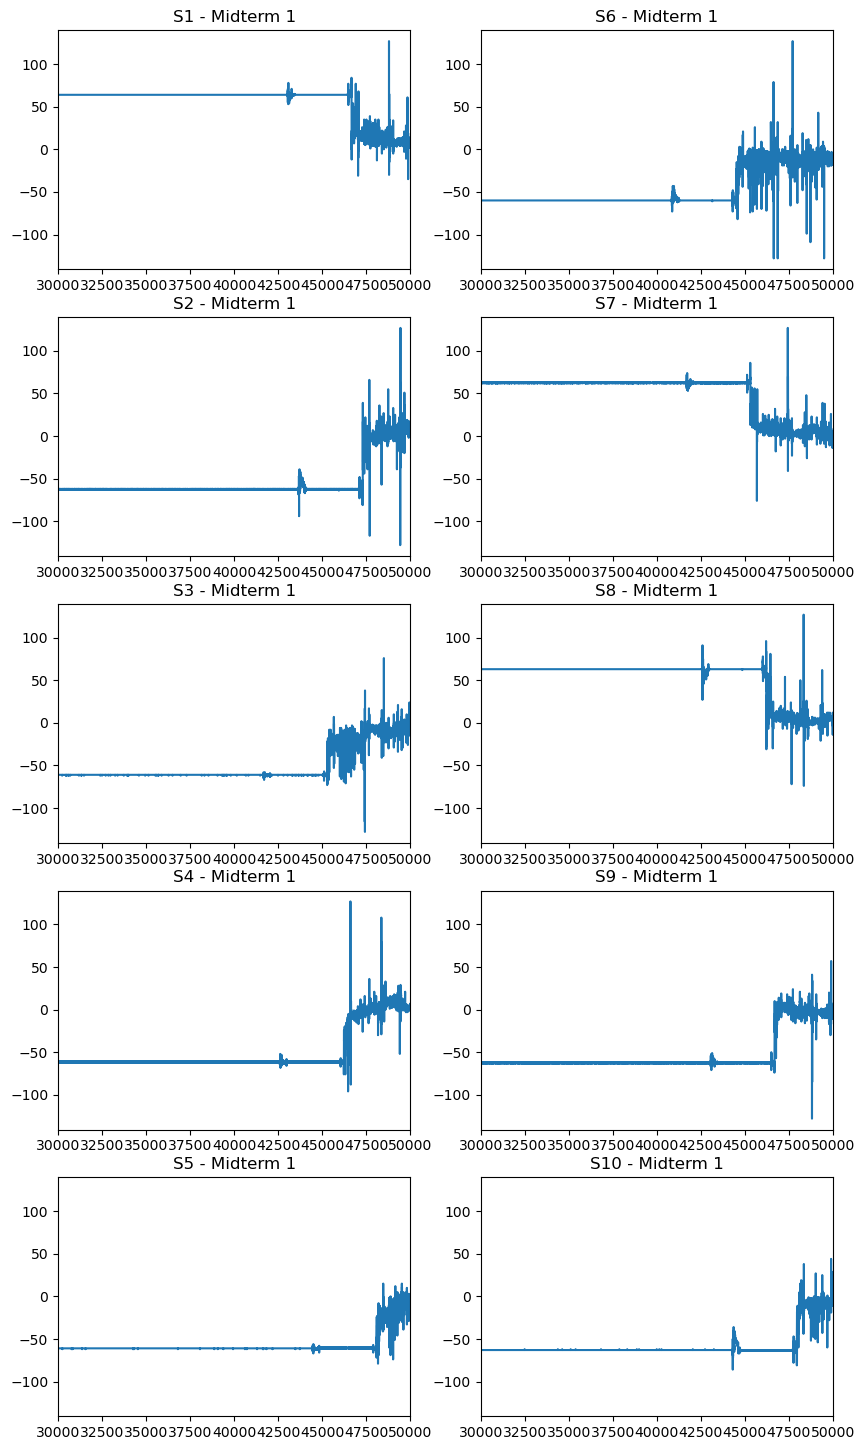

In [11]:
acc_m1, acc_sample_rate_m1 = accy_load("Midterm 1")
accy_plot(acc_m1, "Midterm 1", [30000, 50000])

In [12]:
# Mjerenja od kojih režemo ACC y-os kako bi podatci pokazivali točno vrijeme početka ispita.
acc_m1_cuts = [46000, 47000, 44000, 46000, 47500, 44000, 44000, 45000, 46000, 47000]

In [13]:
eda_m1, eda_sample_rate_m1 = eda_load("Midterm 1", acc_m1_cuts, acc_sample_rate_m1)

In [14]:
m1_5min =  feature_extraction_from_exam(eda_m1, eda_sample_rate_m1, cutoffs["Midterm 1"].values, 90, 5)
m1_15min =  feature_extraction_from_exam(eda_m1, eda_sample_rate_m1, cutoffs["Midterm 1"].values, 90, 15)
m1_30min =  feature_extraction_from_exam(eda_m1, eda_sample_rate_m1, cutoffs["Midterm 1"].values, 90, 30)

In [15]:
m1_y = grade_labeling(m1grades, 100)
print(m1_y)

   0
0  0
1  1
2  0
3  0
4  0
5  0
6  0
7  1
8  1
9  1


In [16]:
m1_5min_knn = KNN_dataframe(m1_5min, m1_y)
m1_15min_knn = KNN_dataframe(m1_15min, m1_y)
m1_30min_knn = KNN_dataframe(m1_30min, m1_y)
accuracy_m1_5min = np.sum(m1_5min_knn) * 10
accuracy_m1_15min = np.sum(m1_15min_knn) * 10
accuracy_m1_30min = np.sum(m1_30min_knn) * 10

In [17]:
print("Midterm 1 - 5 minutes")
print(f"Result: {m1_5min_knn}")
print(f"Accuracy: {accuracy_m1_5min} %")
print()

print("Midterm 1 - 15 minutes")
print(f"Result: {m1_15min_knn}")
print(f"Accuracy: {accuracy_m1_15min} %")
print()

print("Midterm 1 - 30 minutes")
print(f"Result: {m1_30min_knn}")
print(f"Accuracy: {accuracy_m1_30min} %")
print()

Midterm 1 - 5 minutes
Result: [0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]
Accuracy: 70.0 %

Midterm 1 - 15 minutes
Result: [0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0]
Accuracy: 60.0 %

Midterm 1 - 30 minutes
Result: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]
Accuracy: 30.0 %



# Midterm 2

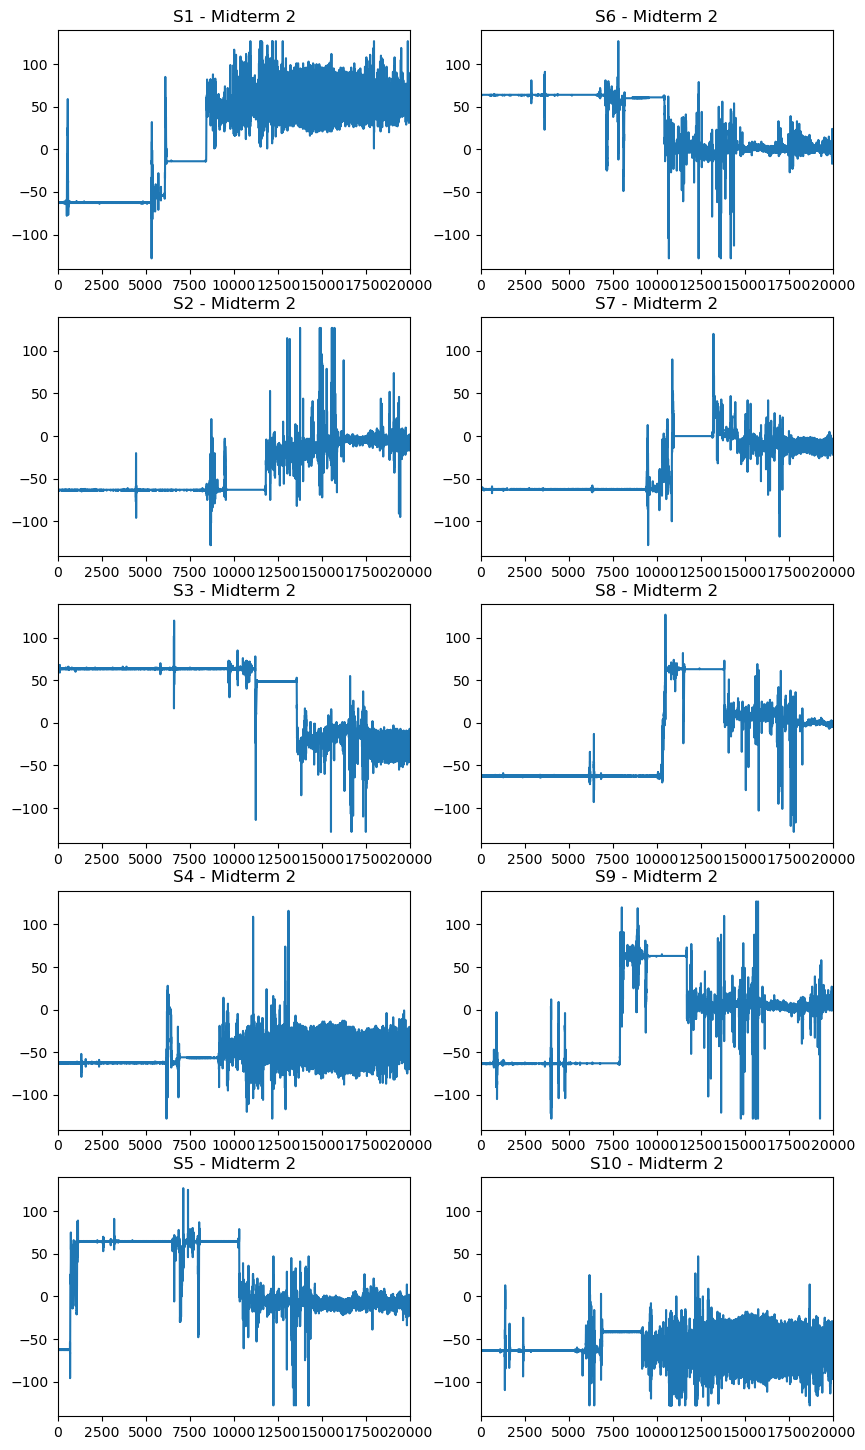

In [18]:
acc_m2, acc_sample_rate_m2 = accy_load("Midterm 2")
accy_plot(acc_m2, "Midterm 2", [0, 20000])

In [19]:
acc_m2_cuts = [5000, 8000, 10000, 6500, 6000, 6000, 8500, 10000, 7500, 6000]

In [20]:
eda_m2, eda_sample_rate_m2 = eda_load("Midterm 2", acc_m2_cuts, acc_sample_rate_m2)

In [21]:
m2_5min =  feature_extraction_from_exam(eda_m2, eda_sample_rate_m2, cutoffs["Midterm 2"].values, 90, 5)
m2_15min =  feature_extraction_from_exam(eda_m2, eda_sample_rate_m2, cutoffs["Midterm 2"].values, 90, 15)
m2_30min =  feature_extraction_from_exam(eda_m2, eda_sample_rate_m2, cutoffs["Midterm 2"].values, 90, 30)

In [22]:
m2_y = grade_labeling(m2grades, 100)
print(m2_y)

   0
0  1
1  1
2  1
3  0
4  0
5  0
6  0
7  1
8  0
9  0


In [23]:
m2_5min_knn = KNN_dataframe(m2_5min, m2_y)
m2_15min_knn = KNN_dataframe(m2_15min, m2_y)
m2_30min_knn = KNN_dataframe(m2_30min, m2_y)
accuracy_m2_5min = np.sum(m2_5min_knn) * 10
accuracy_m2_15min = np.sum(m2_15min_knn) * 10
accuracy_m2_30min = np.sum(m2_30min_knn) * 10

In [24]:
print("Midterm 2 - 5 minutes")
print(f"Result: {m2_5min_knn}")
print(f"Accuracy: {accuracy_m2_5min} %")
print()

print("Midterm 2 - 15 minutes")
print(f"Result: {m2_15min_knn}")
print(f"Accuracy: {accuracy_m2_15min} %")
print()

print("Midterm 2 - 30 minutes")
print(f"Result: {m2_30min_knn}")
print(f"Accuracy: {accuracy_m2_30min} %")
print()

Midterm 2 - 5 minutes
Result: [0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0]
Accuracy: 50.0 %

Midterm 2 - 15 minutes
Result: [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
Accuracy: 80.0 %

Midterm 2 - 30 minutes
Result: [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
Accuracy: 70.0 %



# Final

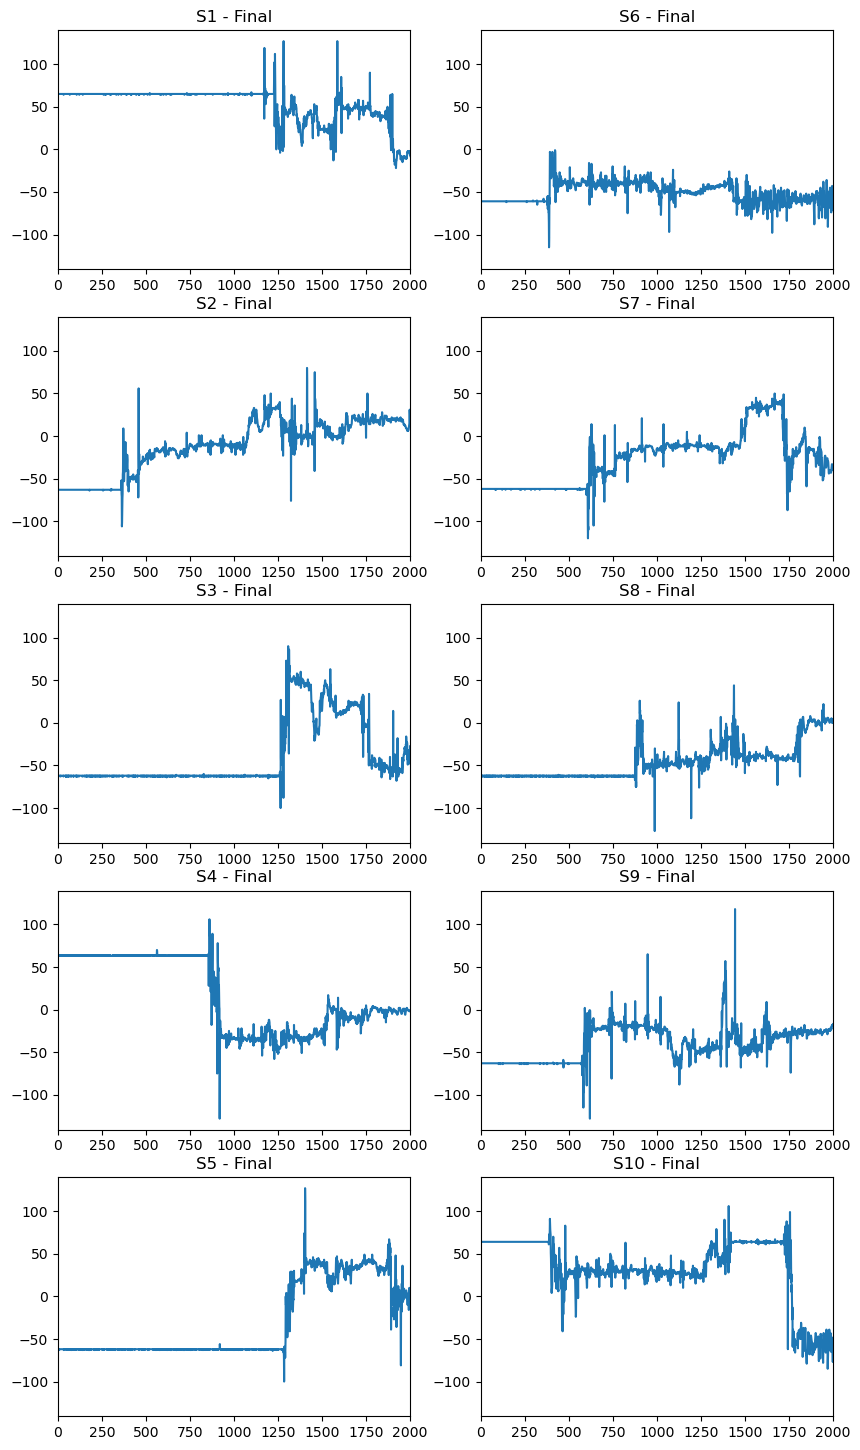

In [25]:
acc_f, acc_sample_rate_f = accy_load("Final")
accy_plot(acc_f, "Final", [0, 2000])

In [26]:
acc_f_cuts = [1100, 300, 1200, 800, 1250, 300, 600, 800, 600, 300]

In [27]:
eda_f, eda_sample_rate_f = eda_load("Final", acc_f_cuts, acc_sample_rate_f)

In [28]:
f_5min =  feature_extraction_from_exam(eda_f, eda_sample_rate_f, cutoffs["Final"].values, 180, 5)
f_15min =  feature_extraction_from_exam(eda_f, eda_sample_rate_f, cutoffs["Final"].values, 180, 15)
f_30min =  feature_extraction_from_exam(eda_f, eda_sample_rate_f, cutoffs["Final"].values, 180, 30)

In [29]:
f_y = grade_labeling(fgrades, 200)
print(f_y)

   0
0  1
1  1
2  1
3  0
4  0
5  1
6  0
7  1
8  0
9  0


In [30]:
f_5min_knn = KNN_dataframe(f_5min, f_y)
f_15min_knn = KNN_dataframe(f_15min, f_y)
f_30min_knn = KNN_dataframe(f_30min, f_y)
accuracy_f_5min = np.sum(f_5min_knn) * 10
accuracy_f_15min = np.sum(f_15min_knn) * 10
accuracy_f_30min = np.sum(f_30min_knn) * 10

In [31]:
print("Final - 5 minutes")
print(f"Result: {f_5min_knn}")
print(f"Accuracy: {accuracy_f_5min} %")
print()

print("Final - 15 minutes")
print(f"Result: {f_15min_knn}")
print(f"Accuracy: {accuracy_f_15min} %")
print()

print("Final - 30 minutes")
print(f"Result: {f_30min_knn}")
print(f"Accuracy: {accuracy_f_30min} %")
print()

Final - 5 minutes
Result: [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0]
Accuracy: 70.0 %

Final - 15 minutes
Result: [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0]
Accuracy: 70.0 %

Final - 30 minutes
Result: [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Accuracy: 50.0 %

